# Prerequisites

## AiiDA Installation
   
   First we begin by installing AiiDA.

In [ ]:
pip install aiida


In [ ]:
!verdi presto

In [ ]:
!verdi status

In [ ]:
!verdi computer list

## Load AiiDA  environment to kernel


We use ```%load_ext``` command  to load the  AiiDA kernel. Next, we load the profile name under which we do the calculations in AiiDA. Since, we only have one profile the explicit name is not provided

In [ ]:
from aiida import load_profile, engine, orm, plugins

%load_ext aiida
load_profile()

# Introduction to AiiDA

The goal of this tutorial is to give you an idea of how AiiDA helps you in executing data-driven workflows. At the end of this tutorial, you will know how to:

* Store data in the database and subsequently retrieve it.

* Decorate a Python function such that its inputs and outputs are automatically tracked.

* Run and monitor the status of processes.

* Explore and visualize the provenance graph.

**Note**
> The syntax of AiiDA is very similar to python, **but remember in AiiDA we are manipulating objects in databases unlike in python**.





> **Technical Note**  
> To my knowledge, the **google** colab environment doesn't support AiiDA **daemon** which is required to queue the calculations. Hence, we won't be using the **daemon** feature in this **tutorial**. For **daemon** functionality on cloud, please use [AiiDALab](https://www.aiidalab.net/deployments/). (Its free for 12 hours provided you have a Github account)

## Provenance

Before we dive in, we need to briefly introduce one of the most important concepts for AiiDA: *provenance*.
An AiiDA database does not only contain the results of your calculations, but also their inputs and each step that was executed to obtain them.
All of this information is stored in the form of a *directed acyclic graph*
As an example, Figure 1 shows the provenance of the calculations of this tutorial.

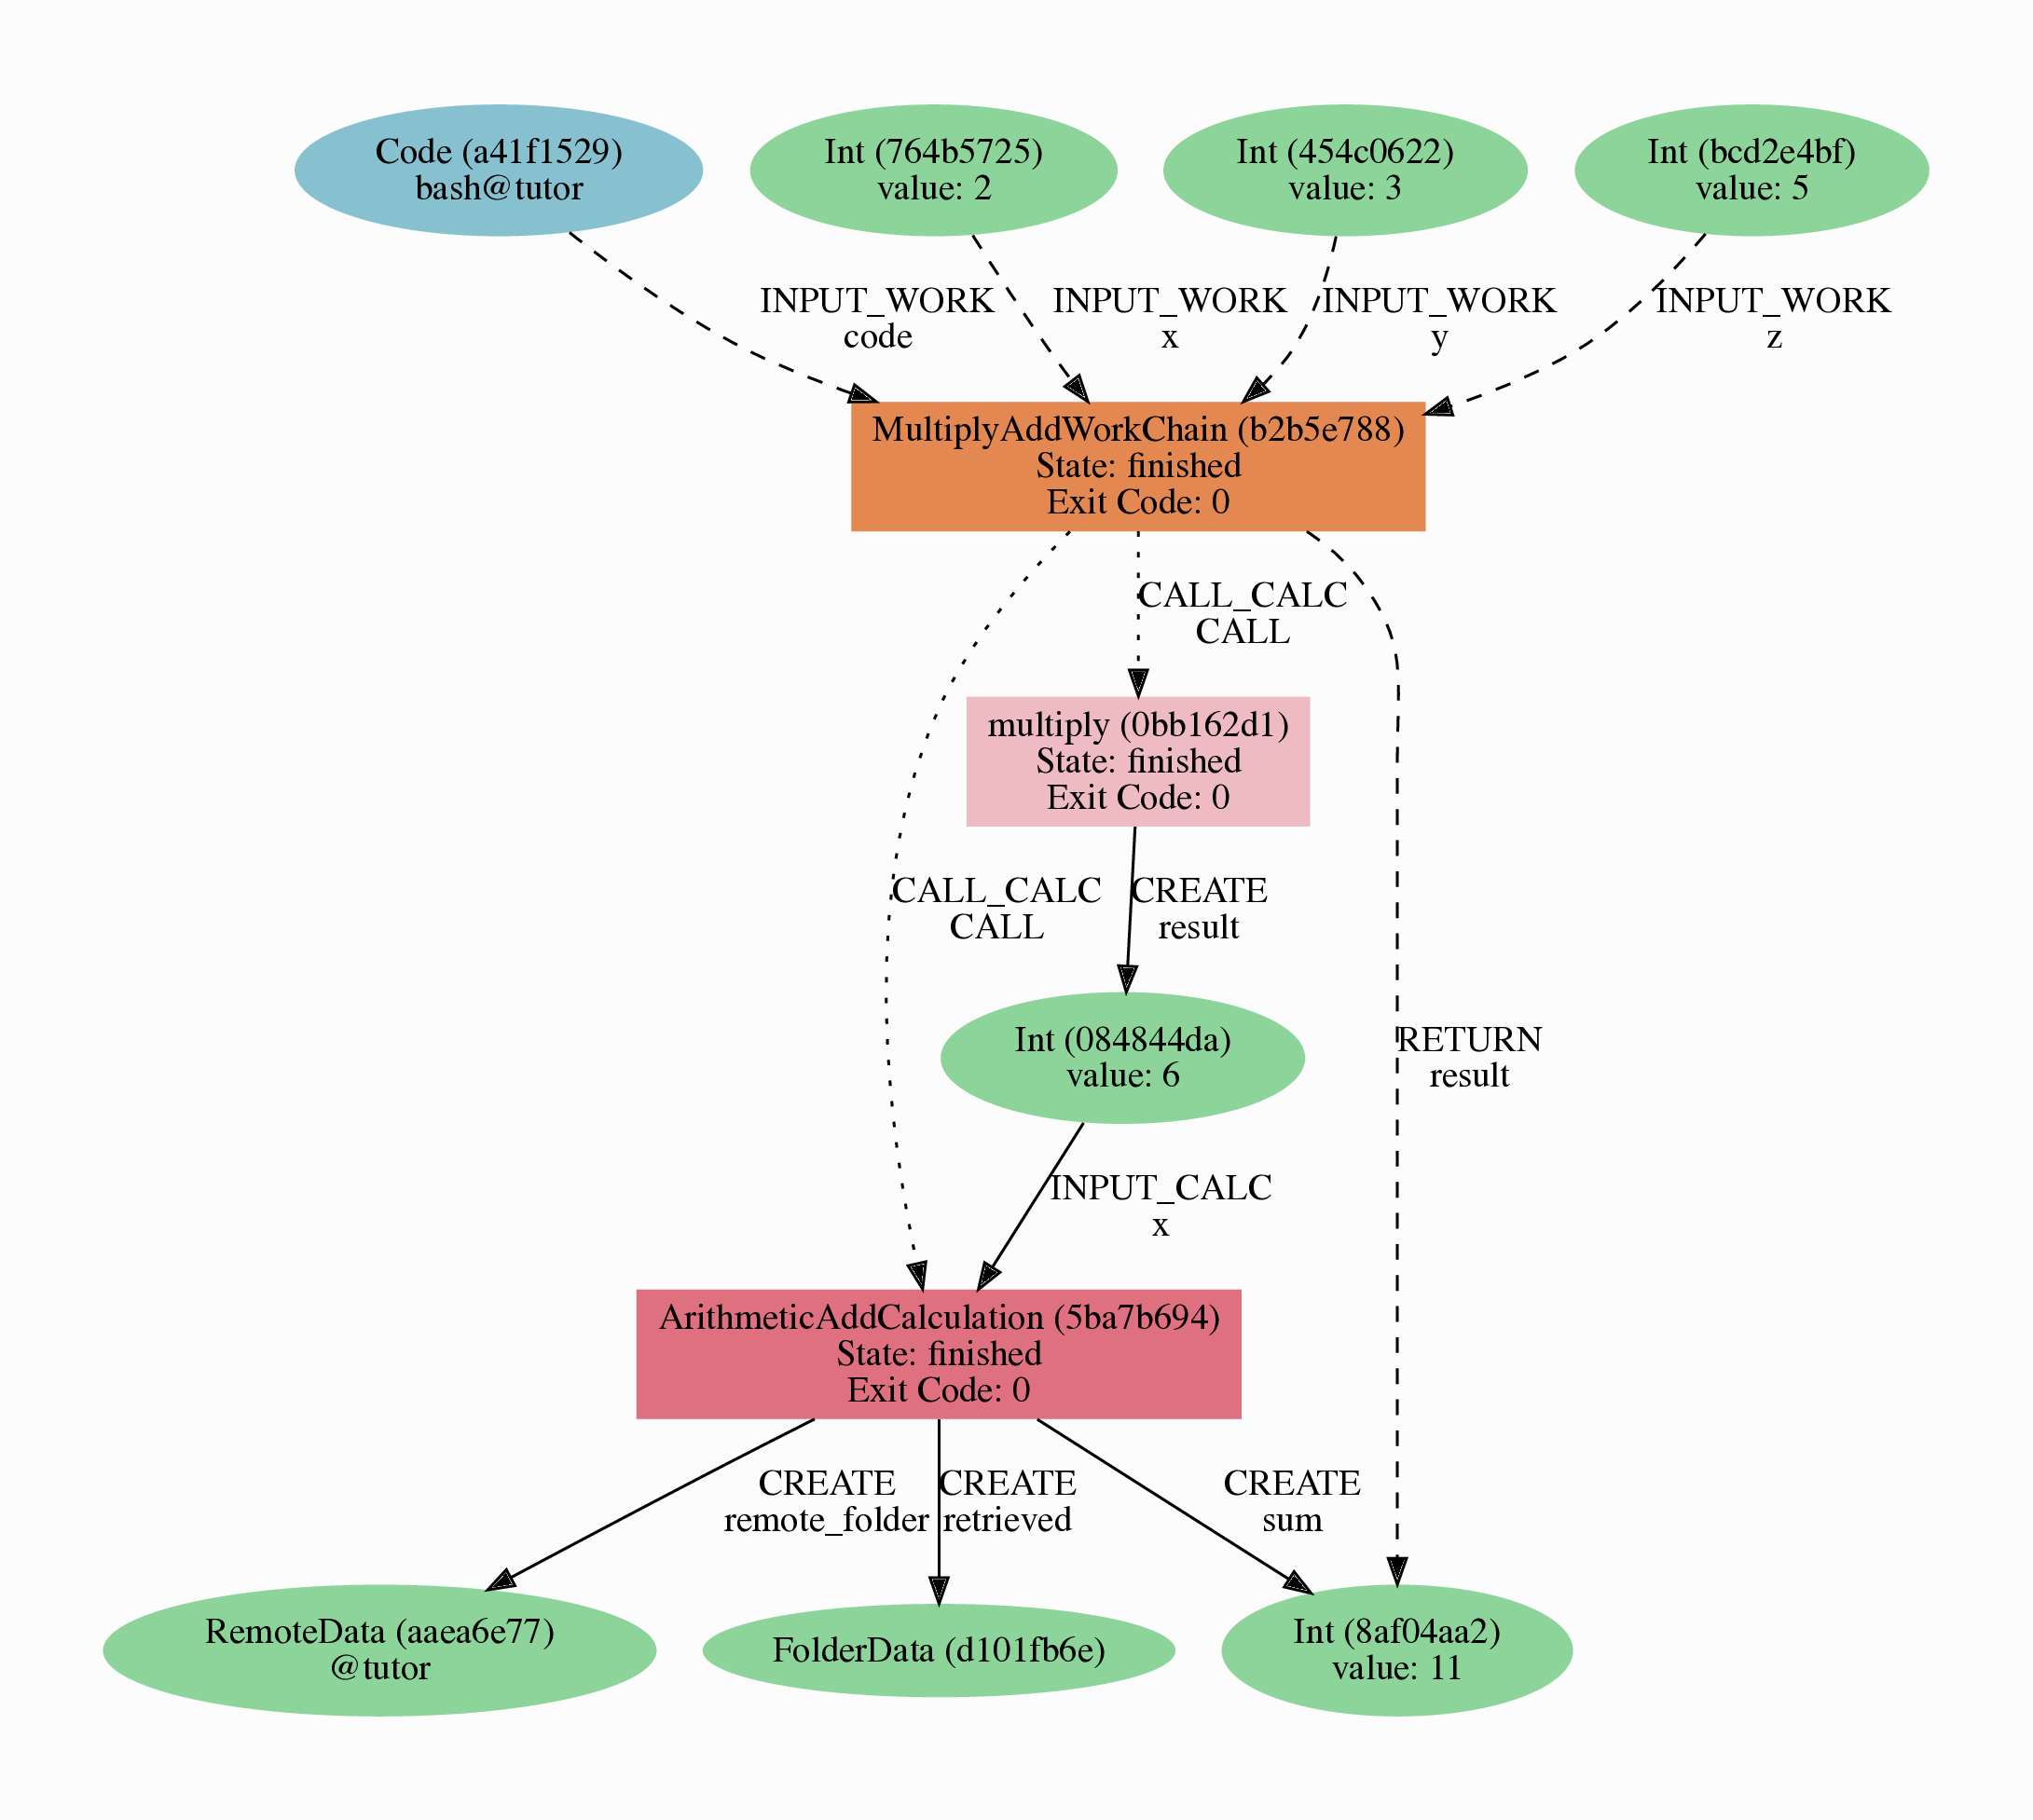

<p align="center">
  <img src=""  width="420">
  <br><em>Figure 1: Provenance graph of a basic AiiDA WorkChain.</em>
</p>

In the provenance graph, you can see different types of *nodes* represented by different shapes.
The green ellipses are `Data` nodes, the blue ellipse is a `Code` node, and the rectangles represent *processes*, i.e. the calculations performed in your *workflow*.

The provenance graph allows us to not only see what data we have, but also how it was produced.
During this tutorial, we will be using AiiDA to generate the provenance graph in Figure 1 step by step.




# Data nodes

Before running any calculations, let's create and store a *data node*.
AiiDA ships with an interactive IPython shell that has many basic AiiDA classes pre-loaded. AiiDA implements data node types for the most common types of data (int, float, str, etc.), which you can extend with your own (composite) data node types if needed. For this tutorial, we'll keep it very simple, and start by initializing an `Int` node and assigning it to the node variable:


In [ ]:
from aiida import orm

node = orm.Int(2)

We can check the contents of the node variable like this:

In [ ]:
node

Quite a bit of information on our freshly created node is returned:

- The data node is of the type `Int`
- The node has the *universally unique identifier* (**UUID**) `eac48d2b-ae20-438b-aeab-2d02b69eb6a8`
- The node is currently not stored in the database `(unstored)`
- The integer value of the node is `2`

Let's store the node in the database:

In [ ]:
node.store()

## PK vs UUID in AiiDA

As you can see, the data node has now been assigned a *primary key* (**PK**), a number that identifies the node in your database (e.g., `pk: 1`).  
Both the **PK** and **UUID** reference the same node, with one key difference:

- **PK**: Unique **only within your local database** (handy in a single interactive session).
- **UUID**: **Globally** unique and suitable for referencing nodes **across different databases**.

Use the **PK** when working within a single database (e.g., in an interactive session), and the **UUID** in all other cases.

> **Important**
>
> - The PK numbers shown in this tutorial assume a completely empty database. Your PKs may differ.
> - UUIDs are generated randomly and are therefore **guaranteed** to be different.


In the terminal, use the `verdi` CLI to check the data node you just created:


# Replace with your actual PK (or use the UUID form shown below)


In [ ]:
verdi node show <Replace with THE pk value>

Once again, we can see that the node is of type Int, has `PK = 1`, and `UUID = bbd0daf6-0962-4f60-b1b6-441ab9bdb761`. Besides this information, the verdi node show command also shows the (empty) label and description, as well as the time the node was created (ctime) and last modified (mtime).

# Processes

## Calculation functions

Once your data is stored in the database, it’s ready to be used for computations.  
For example, multiplying two AiiDA **`Int`** data nodes.

```python

def multiply(x, y):
    return x * y
```

will give the desired result when applied to two `Int` nodes, but the calculation will not be stored in the provenance graph.
However, we can use a [Python decorator](https://docs.python.org/3/glossary.html#term-decorator) provided by AiiDA to automatically make it part of the provenance graph.

Execute the following code snippet:

In [ ]:
from aiida.engine import calcfunction
from aiida.orm import Int

@calcfunction
def multiply(x :Int, y: Int):
    return x * y

This converts the `multiply` function into an AiiDA *calculation function*, the most basic execution unit in AiiDA.
Next, load the `Int` node you have created in the previous section using the `load_node` function and the PK of the data node:

In [ ]:
x = orm.load_node(pk=1)

Of course, we need another integer to multiply with the first one.
Let's create a new `Int` data node and assign it to the variable `y`:

In [ ]:
y = orm.Int(3)

Now it's time to multiply the two numbers!

In [ ]:
multiply(x, y)


Success!
The `calcfunction`-decorated `multiply` function has multiplied the two `Int` data nodes and returned a new `Int` data node whose value is the product of the two input nodes.
Note that by executing the `multiply` function, all input and output nodes are automatically stored in the database:

In [ ]:
y

We had not yet stored the data node assigned to the `y` variable, but by providing it as an input argument to the `multiply` function, it was automatically stored with PK = 2.
Similarly, the returned `Int` node with value 6 has been stored with PK = 4.

Let's  look for the process we have just run using the `verdi` CLI:

In [ ]:
verdi process list


The returned list will be empty, but don't worry! By default, verdi process list only returns the active processes. If you want to see all processes (i.e. also the processes that are terminated), simply add the -a option:

In [ ]:
verdi process list -a

We can see that our `multiply` calcfunction was created 1 minute ago, assigned the PK 3, and has `Finished`.

As a final step, let's have a look at the provenance of this simple calculation.
The provenance graph can be automatically generated using the verdi CLI.
Let's generate the provenance graph for the `multiply` calculation function we have just run with PK = 3:

```console
$ verdi node graph generate 3
```

The command will write the provenance graph to a `.pdf` file.
Use your favorite PDF viewer to have a look.
It should look something like the graph shown below.

In [ ]:
verdi node graph generate 3

In [ ]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(3)
graph.add_incoming(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

> **Note**  
> Remember that the PK of the `calcfunction` can be different for your database.

## CalcJobs

When running calculations that require an external code or run on a remote machine, a simple calculation function is no longer sufficient.  
For this purpose, AiiDA provides the `CalcJob` process class.

To run a `CalcJob`, you need to set up two things: a **code** that implements the desired calculation and a **computer** for the calculation to run on.

 If you’re on your own machine, follow the steps below.

> **See also:** How to run external codes in AiiDA.

---

### Define computer

The local  **computer** is already defined by default as **localhost**. For this tutorial, we would be running everything on local machine. A typical real-world example of a computer is a remote supercomputing facility.
Codes can be anything from a Python script to powerful *ab initio* codes such as Quantum Espresso or machine learning tools like Tensorflow.

Use the following command to see the computer available.

In [ ]:
verdi computer 'list'

### Define code

In AiiDA, external codes are interfaced through **plugins**, which are classified according to specific groups. We are going to use **add** plugin ( addition operation in bash) for this tutorial. To see the available plugins use the following command

---



In [ ]:
verdi plugin list

In [ ]:
verdi plugin list aiida.calculations

Next, let's set up the code we're going to use for the tutorial:

In [ ]:
verdi code create core.code.installed -L add --computer=localhost -P core.arithmetic.add --filepath-executable=/bin/bash -n

This command sets up a code with *label* `add` on the *computer* `tutor`, using the **plugin** `core.arithmetic.add`.

In [ ]:
!verdi code list

You can see a single code `add@localhost`, with PK = 5, in the printed list.
This code allows us to add two integers together.
The `add@localhost` identifier indicates that the code with label `add` is run on the computer with label `localhost`.
To see more details about the computer, you can use the following `verdi` command:

In [ ]:
verdi computer show localhost

The **Work directory** is set to the `work`.  This is where calculations that run on the `localhost` computer will execute.

> **Note**  
> You may notice that the PK of the `localhost` computer is `1`, the same as the `Int` node created earlier.  
> That’s because different entity types (nodes, computers, groups) live in **separate database tables**.  
> PKs are unique **within each table**, so different entity types can share the same PK value in one database.



In [ ]:
code = orm.load_code(label='add')
code

Every code has a convenient tool for setting up the required input, called the *builder*.
It can be obtained by using the `get_builder` method:

In [ ]:
builder = code.get_builder()
builder

Using the builder, you can easily set up the calculation by directly providing the input arguments.
Let's use the `Int` node that was created by our previous `calcfunction` as one of the inputs and a new node as the second input:

In [ ]:
builder.x = orm.load_node(pk=4)
builder.y = orm.Int(5)
builder

In case that your nodes' PKs are different and you don't remember the PK of the output node from the previous calculation, check the provenance graph you generated earlier and use the UUID of the output node instead:

```ipython
In [3]: builder.x = orm.load_node(uuid='42541d38')
   ...: builder.y = orm.Int(5)
```

Note that you don't have to provide the entire UUID to load the node.
As long as the first part of the UUID is unique within your database, AiiDA will find the node you are looking for.



To execute the `CalcJob`, we use the `run` function provided by the AiiDA engine, and wait for the process to complete:

In [ ]:
engine.run(builder)

Besides the sum of the two `Int` nodes, the calculation function also returns two other outputs: one of type `RemoteData` and one of type `FolderData`.

In [ ]:
verdi process list -a

You should now see two processes in the list.
One is the `multiply` calcfunction you ran earlier, the second is the `ArithmeticAddCalculation` CalcJob that you have just run.
Grab the PK of the `ArithmeticAddCalculation`, and generate the provenance graph.
The result should look like the graph shown below.

```console
$ verdi node graph generate 7
```

In [ ]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(7)
graph.recurse_ancestors(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

You can see more details on any process, including its inputs and outputs, using the verdi shell:

In [ ]:
verdi process show 7

## Workflows

So far we have executed each process manually.
AiiDA allows us to automate these steps by linking them together in a *workflow*, whose provenance is stored to ensure reproducibility.
For this tutorial we have prepared a basic `WorkChain` that is already implemented in `aiida-core`.
You can see the code below:



First, we recognize the `multiply` function we have used earlier, decorated as a `calcfunction`.
The `define` class method specifies the `input` and `output` of the `WorkChain`, as well as the `outline`, which are the steps of the workflow.
These steps are provided as methods of the `MultiplyAddWorkChain` class.


> **Note**  
> The goal is not to completely understand the python code written below. Its an example to show the construction of workflows in AiiDA.

> This code can be loaded by default in AiiDA from the `WorkflowFactory` as shown in subsequent steps.



In [ ]:
from aiida.engine import ToContext, WorkChain, calcfunction
from aiida.orm import AbstractCode, Int
from aiida.plugins.factories import CalculationFactory

ArithmeticAddCalculation = CalculationFactory('core.arithmetic.add')


@calcfunction
def multiply(x, y):
    return x * y


class MultiplyAddWorkChain(WorkChain):
    """WorkChain to multiply two numbers and add a third, for testing and demonstration purposes."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input('x', valid_type=Int)
        spec.input('y', valid_type=Int)
        spec.input('z', valid_type=Int)
        spec.input('code', valid_type=AbstractCode)
        spec.outline(                                 # This line defines the order of execution of our workflow
            cls.multiply,
            cls.add,
            cls.validate_result,
            cls.result,
        )
        spec.output('result', valid_type=Int)
        spec.exit_code(400, 'ERROR_NEGATIVE_NUMBER', message='The result is a negative number.')

    def multiply(self):
        """Multiply two integers."""
        self.ctx.product = multiply(self.inputs.x, self.inputs.y)

    def add(self):
        """Add two numbers using the `ArithmeticAddCalculation` calculation job plugin."""
        inputs = {'x': self.ctx.product, 'y': self.inputs.z, 'code': self.inputs.code}
        future = self.submit(ArithmeticAddCalculation, **inputs)

        return ToContext(addition=future)

    def validate_result(self):
        """Make sure the result is not negative."""
        result = self.ctx.addition.outputs.sum

        if result.value < 0:
            return self.exit_codes.ERROR_NEGATIVE_NUMBER

    def result(self):
        """Add the result to the outputs."""
        self.out('result', self.ctx.addition.outputs.sum)

> **Note**  
> Besides WorkChains, workflows can also be implemented as **work functions**.  
> These are ideal for lightweight workflows that fit in a single Python function.

## Run the `MultiplyAddWorkChain`

Start the AiiDA shell and load the WorkChain via `WorkflowFactory`:


In [ ]:
from aiida import plugins
MultiplyAddWorkChain = plugins.WorkflowFactory('core.arithmetic.multiply_add')

The `WorkflowFactory` loads workflows based on their **entry point** (e.g. `'core.arithmetic.multiply_add'`).
The entry point system lets AiiDA discover workflows from `aiida-core` and installed plugins, and list them for you.

Similar to a `CalcJob`, the `WorkChain` input can be set up using a builder:

In [ ]:
from aiida import orm
builder = MultiplyAddWorkChain.get_builder()
builder.code = orm.load_code(label='add')
builder.x = orm.Int(2)
builder.y = orm.Int(3)
builder.z = orm.Int(5)
builder

In [ ]:
from aiida import engine
engine.run(builder)

In [ ]:
verdi process list -a

If instead we had submitted to the **daemon**, we would see the the process status of the workchain and its dependants:

```console
$ verdi process list -a
  PK  Created    Process label             Process State    Process status
----  ---------  ------------------------  ---------------  ------------------------------------
   3  7m ago     multiply                  ⏹ Finished [0]
   7  3m ago     ArithmeticAddCalculation  ⏹ Finished [0]
  12  2m ago     ArithmeticAddCalculation  ⏹ Finished [0]
  19  16s ago    MultiplyAddWorkChain      ⏵ Waiting        Waiting for child processes: 22
  20  16s ago    multiply                  ⏹ Finished [0]
  22  15s ago    ArithmeticAddCalculation  ⏵ Waiting        Waiting for transport task: retrieve

Total results: 6

Info: last time an entry changed state: 0s ago (at 09:08:59 on 2020-05-13)
```

:::

We can see that the `MultiplyAddWorkChain` is currently waiting for its *child process*, the `ArithmeticAddCalculation`, to finish.
Check the process list again for *all* processes (You should know how by now!).
After about half a minute, all the processes should be in the `Finished` state.
The `verdi process status` command prints a *hierarchical* overview of the processes called by the work chain:

In [ ]:
verdi process status 14

The bracket `[3:result]` indicates the current step in the outline of the `~aiida.workflows.arithmetic.multiply_add.MultiplyAddWorkChain` (step 3, with name `result`).
The `process status` is particularly useful for debugging complex work chains, since it helps pinpoint where a problem occurred.

We can now generate the full provenance graph for the `WorkChain` with:

```console
$ verdi node graph generate 14
```

In [ ]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(14)
graph.recurse_ancestors(calc_node, annotate_links="both")
graph.recurse_descendants(calc_node, annotate_links="both")
graph.graphviz

Look familiar?
The provenance graph should be similar to the one we showed at the start of this tutorial (ref Fig. 1).

# Next Steps

Congratulations! You have completed the first step to becoming an AiiDA expert.